In [2]:
# %load ../Code/Fits.py
import Estimation as st
from Histogram import Histogram as hist
from PDF import PDF
from Utils import IsotopeDic, PartDic
from scipy.stats import poisson
import scipy.optimize as sop
import numpy as np
from scipy.special import gammaln
from copy import copy

def generalLogPoisson(x,mu):
    return -mu+x*np.log(mu+0.001)-gammaln(x+1)


class Fit():
    '''
    Class meant to perform the fit
    '''
    def __init__(self, E, spectrum, PDFs):
        '''
        E: x range (np array)
        spectrum: experimental points
        PDF: list of spectra PDFs
        nevs: normalizations for the spectra (they are the
            initial values for the fit)
        '''
        self.E = E[:]
        self.Ep = np.linspace(0.5,2.8,100)
        self.spectrum = spectrum.hist[:]
        for i in PDFs:
            print(i.Int)
        self.PDFs = copy(PDFs)#[pdf.Scale(1./pdf.Int) for pdf in PDFs]
        for i in PDFs:
            print(i.Int)

    def LogLikelihood(self, nevs):
        '''
        function meant to compute the LogLikelihood
        '''
        #print(self.PDFs,nevs)
        for i in nevs:
            if i<0.: return 1e12
        ypdf = np.array([sum([n*pdfi.pdf(Ei) for pdfi,n in zip(self.PDFs,nevs)]) for Ei in self.E])
        ydat = self.spectrum
        #print(type(ydat))
        #print(type(ypdf))
        lm = (np.array(generalLogPoisson(ydat,ypdf))).sum()


        return -lm

    def FitLLM(self,nevs, **kwargs):
        nevs = np.array(nevs)
        fit = self.LogLikelihood
        res = sop.minimize(fit,nevs,method='Nelder-Mead',**kwargs)
        ypdf = np.array([sum([n*pdfi.pdf(Ei) for pdfi,n in zip(self.PDFs,res.x)]) for Ei in self.E])

        ydat = self.spectrum

        plt.plot(self.E,ypdf)
        plt.plot(self.E,ydat,'+')
        plt.semilogy()
        plt.ylim([1e-1,3e3])
        chi2 = -1
        if (res.success):
            chi2 = np.sum((ypdf-ydat)**2)/(1.*(len(ypdf)-len(nevs)))
        res.chi2 = chi2
        return res

    def LeastSQ(self,nevs):
        ypdf = np.array([sum([n*pdfi.pdf(Ei) for pdfi,n in zip(self.PDFs,nevs)]) for Ei in self.E])
        ydat = self.spectrum
        return np.power(ypdf-ydat,2).sum()

    def FitLeastSQ(self,nevs,**kwargs):
        nevs = np.array(nevs)
        fit = self.LeastSQ
        res = sop.minimize(fit,nevs,method='Nelder-Mead',**kwargs)
        ypdf = np.array([sum([n*pdfi.pdf(Ei) for pdfi,n in zip(self.PDFs,res.x)]) for Ei in self.E])
        ydat = self.spectrum
        chi2 = -1
        plt.plot(self.E,ypdf)
        plt.plot(self.E,ydat,'+')
        if (res.success):
            chi2 = np.sum((ypdf-ydat)**2)/(1.*(len(ypdf)-len(nevs)))
        res.chi2 = chi2
        return res


In [3]:
auxlist = np.random.normal(5,1.5,10000000)
a = hist(auxlist,100,0,15)
b = hist(auxlist+3,100,0,15)

In [4]:
ap = PDF(a,interpolation='linear')
bp = PDF(b,interpolation='linear')

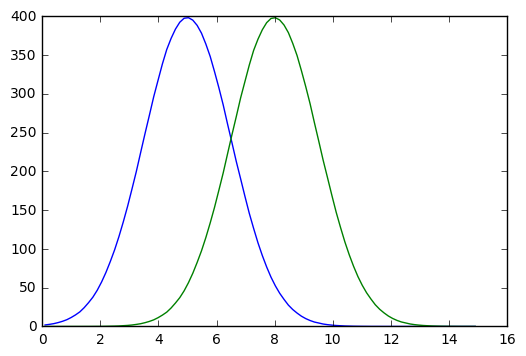

In [5]:
import matplotlib.pylab as plt
%matplotlib inline
x = np.linspace(0.1,14.9,100)
ya = 10000*ap.pdf(x)
yb = 10000*bp.pdf(x)
plt.plot(x,ya)
plt.plot(x,yb)

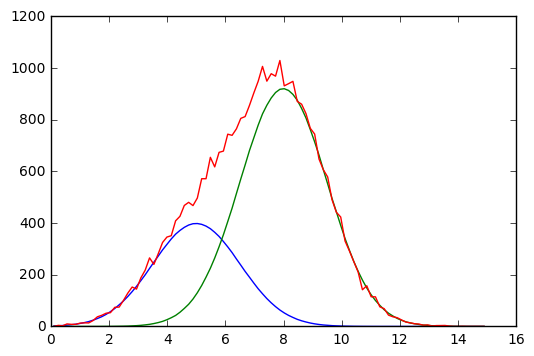

In [6]:
ydata = np.abs(np.random.normal(ya+2.31*yb,np.sqrt(ya+2.31*yb)))
hdata = hist([],100,0,15)
hdata.hist = ydata
hdata.bins = x
plt.plot(x,ya)
plt.plot(x,2.31*yb)
plt.plot(x,ydata)

In [7]:
fit = Fit(x,hdata,[ap,bp])

0.15
0.15
0.15
0.15


In [8]:
w = fit.LogLikelihood([100.,100.])
#plt.plot(x,e)
#plt.plot(x,r)


1 loop, best of 3: 808 ms per loop


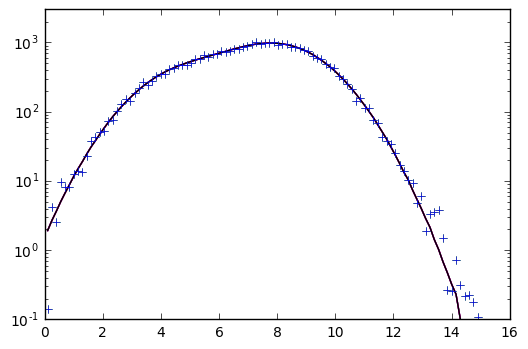

In [12]:
%timeit fit.FitLLM([1000.,30000.])

In [10]:
a = hist([],100,0,10)

          chi2: 259.84214410889285
 final_simplex: (array([[ 10054.65644039,  23078.06679307],
       [ 10054.65644039,  23078.06679306],
       [ 10054.65644039,  23078.06679306]]), array([ 25464.53012267,  25464.53012267,  25464.53012267]))
           fun: 25464.530122671502
       message: 'Optimization terminated successfully.'
          nfev: 245
           nit: 120
        status: 0
       success: True
             x: array([ 10054.65644039,  23078.06679307])

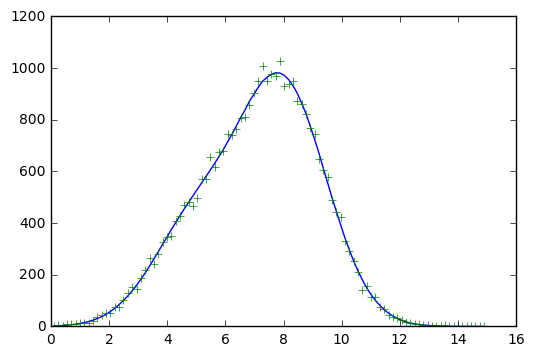

In [11]:
fit.FitLeastSQ([100.,100.],tol=1e-8,options={"maxiter":1000})